# Computational Methods in Economics

## Exam Question

In [8]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn


In [11]:
## The given values from the question sheet

##utilities
beta = 0.9      # discount factor
nu = 2          # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
B = 1

## production
alpha = 0.25
gamma = 0.05
A = 1

rho = 0.1       # marginal cost of clean energy
phi = 0.5       # share of pollutant that remains in the air between two periods

## initial values
s0 = 0.05

pm = {'beta': beta, 'nu': nu, 'eta': eta, 'alpha': alpha, 'gamma': gamma,
          'phi': phi, 'rho': rho, 'A': A, 'B': B }


In [14]:
## define the output function in the question

def f(x,pm):

    return np.exp(-x[0]) * pm['A'] * (x[0]-pm['phi']*x[0])**pm['alpha'] * x[1]**pm['gamma'] * x[2]**(1- pm['alpha']-pm['gamma'])

## let's define the first derivative of the output function with respect to dirty energy, clean energy, and labor

def f_diff(x,pm):
 
    return (pm['alpha']*f(x,pm)/(x[0]-pm['phi']*x[0]), 
            pm['gamma']*f(x,pm)/x[1],
            (1- pm['alpha']-pm['gamma'])*f(x,pm)/x[2]
            )

## To returns a new array of given shape and type, where the element’s value as 0 (for optimization)

def steady(x, pm):

    y = np.zeros(3)
    
    mp = f_diff(x, pm)
    y[0] = (mp[0]) - pm['beta']* (mp[0])*((x[0]-pm['phi']*x[0])/pm['alpha']+pm['phi'])
    y[1] = pm['beta'] * (f(x,pm) - pm['rho'] * x[1]) **(-pm['nu']) * (mp[1] - pm['rho'])
    y[2] = pm['beta'] * (f(x,pm) - pm['rho'] * x[1]) **(-pm['nu']) * mp[2] - pm['beta']*pm['B']*x[2]**pm['eta']
    return y

In [15]:
## Compute steady state values of the model by scipy's package optimize root function

res_ss = scipy.optimize.root(steady, x0, args = (pm), method = 'broyden1')

print(res_ss)
sss = res_ss.x[0]
rss = res_ss.x[1]
hss = res_ss.x[2]

ess = (1-pm['phi']) * sss
print(ess)
print( "Steady state: (e_ss, r_ss, h_ss) = {}".format(res_ss.x ) )


     fun: array([-2.23494323e-09, -2.48076276e-10, -6.17591533e-10])
 message: 'A solution was found at the specified tolerance.'
     nit: 23
  status: 1
 success: True
       x: array([0.30555556, 0.25043399, 1.24441083])
0.1527777785352399
Steady state: (e_ss, r_ss, h_ss) = [0.30555556 0.25043399 1.24441083]


In [18]:
##for part b,I use iterative methods for both the value function by Chebyshev approximation and therefore define chebychev nodes and grids

def chebnodes(m):
#Numerical experience suggests polynomial fe over a bounded interval [a, b] should use Chebyshev nodes.
#P.s:the Chebyshev nodes are the roots of the Chebyshev polynomials ψj (x).

    i = np.array(list(range(1, m+1)))
    
#The Chebyshev nodes are the j roots of the Chebyshev polynomials ψj(x) which are actually defined on the [−1, 1] interval. 
#These j roots are found by the below formula:

    return -np.cos(0.5 * np.pi * (2 * i - 1) / m)
#These nodes are not evenly spaced. They are more closely spaced near the endpoints of the interpolation interval
#and less so near the center—this avoids more easily instabilities at the endpoints.

#We can extend the grid [−1, 1] to any bounded interval [a, b] by linearly transforming the nodes:
def chebgrid(a, b, m):

    z = chebnodes(m)
    return (b - a) * 0.5 * (z + 1) + a 

def chebconvert(x, a, b):

    return 2. * (x - a) / (b - a) - 1


#Moreover, the error bound goes to zero as n arises.
#We can achieve any desired degree of accuracy with polynomials fe interpolated at a sufficiently large number of Chebyshev nodes.


def chebmatrix(deg, m = None, x = None):

#The Chebyshev interpolation matrix is orthogonal with Euclidean norm condition number, regardless of the degree of interpolation, very close to the absolute minimum of 1. This
#means that Chebyshev basis coefficients, θj, can be computed quickly and accurately, regardless of the degree of interpolation.

    assert (m != None or np.sum(x) != None)

    if x is None: 
        z = chebnodes(m)
    elif isinstance(x, (list, tuple, np.ndarray)):  
        z, m  = x, len(x) 
    else: 
        z, m = x, 1 

    
    T = np.ones((m, deg + 1))
    T[:,1] = z
    
  
    for col_idx in range(1, deg):
        T[:,col_idx+1] = 2 * z * T[:,col_idx] - T[:,col_idx - 1]
    return T

# Approximate f (x) on [a, b]. I will use m (n+1) interpolation nodes (info) to construct polynomial approximation
# n evenly spaced interpolation nodes yield, degree


def chebapprox(y, deg, v = None):

    m = len(y)
    T = chebmatrix(deg, m)
    
    if deg == m-1:
        coef = np.linalg.solve(T,y)
    else:
        coef = np.ones(deg + 1)
        for idx_deg in range(deg + 1):
            coef[idx_deg] = sum(y * T[:,idx_deg]) / sum(T[:,idx_deg]**2)
            
    return coef 

In [19]:
m = 10
s_min = 0.03
s_max = 0.35
s_grid = chebgrid(s_min, s_max, m)

n = m - 1

##For value function iteration, I use  V**(0)(s)= -s**2
V0 = -(s_grid**2)

a0 = chebapprox(V0, n)

In [14]:
##define utilitiy function

def u(c, h, pm):

    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])

def f(s,sp,r,h,pm):

    return np.exp(-s) * pm['A'] * (sp-pm['phi']*s)**pm['alpha'] * r**pm['gamma'] * h**(1- pm['alpha']-pm['gamma'])

In [15]:
def vf_rhs(x, s, a, s_min, s_max, pm):

    sp = np.exp(x[0])
    r = np.exp(x[1])
    h = np.exp(x[2])
    
    current_util = u(f(s,sp,r,h,pm) - pm['rho']*r, h, pm)
    cont_value = np.polynomial.chebyshev.chebval(chebconvert(sp, s_min, s_max), a)
    return - (current_util + pm['beta'] * cont_value )

In [16]:
x0 = (0, 0, 0)
V = np.zeros(m) 
for (ind, s) in enumerate(s_grid):

    res = scipy.optimize.minimize(vf_rhs, x0, args = (s, a0, s_min, s_max, pm), method ='BFGS') 
    V[ind] = - res.fun
    print(res.message)
    
def opt_step(s_grid, obj_fun, x0, a_ch, s_min, s_max, pm):     

    V = np.zeros(m)
    Sp = np.zeros(m)
    R = np.zeros(m)
    H = np.zeros(m)
    

    for (ind, s) in enumerate(s_grid):

        res = scipy.optimize.minimize(obj_fun, x0, args = (s, a_ch, s_min, s_max,pm), method ='BFGS') 
        V[ind] = - res.fun
        Sp[ind], R[ind], H[ind]= np.exp( res.x )

    return V, Sp, R, H

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


In [17]:
a = chebapprox(V, n)

In [18]:
a_ch = a0.copy()
x0 = (0, 0,0)

eps = 1
it = 0
maxit = 100

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, S, R, H = opt_step(s_grid, vf_rhs, x0, a_ch, s_min, s_max, pm)
    ## fitting step
    a_new = chebapprox(V, n)
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()

print(it, eps)

100 8.581991802358868e-05


In [19]:
a_ch = a0.copy()
eps = 1
it = 0
maxit = 100

ValueError: too many values to unpack (expected 3)

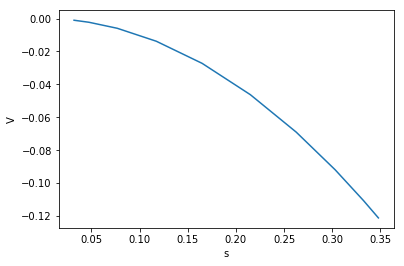

In [23]:
fig, ax = plt.subplots()
ax.plot(s_grid, V0)
ax.set_xlabel('s')
ax.set_ylabel('V')

while eps > 1e-8 and it < maxit:
    it += 1
    V, S, H = opt_step(s_grid, vf_rhs, x0, a_ch, s_min, s_max, pm)
    ax.plot(s_grid, V)

    a_new = chebapprox(V, n)

    eps = np.linalg.norm(a_new - a_ch)

    a_ch = a_new.copy()

In [21]:
a_s = chebapprox(S, n)
a_r = chebapprox(R, n)
a_h = chebapprox(H, n)

T = 30

st = np.zeros(T+1)
rt = np.zeros(T)
ht = np.zeros(T)
et = np.zeros(T)


st[0] = s0

for t in range(T):
    st[t+1] = np.polynomial.chebyshev.chebval( 
                chebconvert(st[t], s_min, s_max), a_s )
    rt[t] = np.polynomial.chebyshev.chebval( 
                chebconvert(st[t], s_min, s_max), a_r )
    ht[t] = np.polynomial.chebyshev.chebval( 
                chebconvert(st[t], s_min, s_max), a_h )
    et[t] = st[t+1] - pm['phi']*st[t]

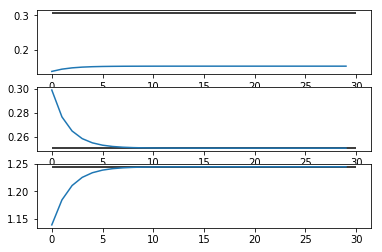

In [22]:
fig, bx = plt.subplots(3,1)
bx[0].plot(range(T), et)
bx[0].hlines(ess, 0, T)
bx[1].plot(range(T), rt)
bx[1].hlines(rss, 0, T)
bx[2].plot(range(T), ht)
bx[2].hlines(hss, 0, T)